# Expanding Nutri-Score : take your menu to the next level

In [1]:
import pandas as pd
import numpy as np
from numpy import isnan
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from computeNutriScore import computeNutriScore

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

## OpenFoodFacts Dataset Exploration

### Loading & Cleaning

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


In [6]:
data_food.head()

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0000000001281,Tarte noix de coco,"en:pies,en:sweet-pies,en:coconut-pies",1594.0,22.0,15.5,21.9,0.100,0.039370,NaN,NaN,4.4,4.6
0000000001885,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",657.0,0.0,0.0,27.0,0.000,0.000000,NaN,NaN,3.6,0.6
0000000005470,BAguette bressan,"en:plant-based-foods-and-beverages,en:plant-ba...",669.0,2.2,0.5,0.6,0.358,0.140945,NaN,NaN,1.6,9.5
0000000005661,Pavé de saumon fumé à la ficelle,"en:seafood,en:fishes,en:salmons,en:smoked-fish...",1059.0,17.0,2.6,0.5,2.500,0.984252,NaN,NaN,NaN,23.0
0000000020114,Naturablue original,en:dietary-supplements,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [4]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,1.480730e+05,146533.000000,143766.000000,144222.000000,142788.000000,142785.000000,2939.000000,7466.000000,7.827000e+04,147298.000000
mean,1.200323e+03,14.601458,5.781768,16.718755,2.549246,1.003761,43.438452,43.996718,7.116702e+04,7.481971
std,1.284265e+04,190.279516,51.635586,342.593733,146.659602,57.742793,33.508329,29.703503,1.990937e+07,52.067622
min,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-6.670000e+00,-5.560000
25%,3.470000e+02,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,14.000000,0.000000e+00,0.900000
50%,9.950000e+02,5.700000,1.690000,4.500000,0.356000,0.140000,43.000000,50.000000,1.500000e+00,5.100000
75%,1.648000e+03,21.200000,7.400000,19.000000,1.168400,0.460000,65.000000,63.000000,3.400000e+00,9.700000
99%,3.700000e+03,93.300000,45.000000,82.000000,11.073900,4.358545,100.000000,100.000000,2.000000e+01,30.900000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,11800.000000


In [5]:
def Complete_ratio_column(df):
    '''Give an idea of the filling of the columns of a given dataset'''
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 86.001 % is complete
For fat_100g, 85.107 % is complete
For saturated-fat_100g, 83.5 % is complete
For sugars_100g, 83.765 % is complete
For salt_100g, 82.932 % is complete
For sodium_100g, 82.93 % is complete
For fruits-vegetables-nuts_100g, 1.707 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.336 % is complete
For fiber_100g, 45.46 % is complete
For proteins_100g, 85.551 % is complete


In [7]:
def Compute_energy(Fat, Sugar, Prot, Fiber, Marge):
    '''Compute energy with a marge of 100 kJ'''

    energy = (37 * Fat + 17 * (Sugar + Prot) + 8 * Fiber) - Marge
    if energy < 0:
        return 0
    return energy

In [8]:
# Put NaN for incoherent values or give a valid value
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        # Salt / Sodium        
        if isnan(df.iat[i, 6]):
            if ~isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
        
        # Saturated Fat / Fats                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        # Fruit-Vegetables-Nut Real / Estimate
        if ~isnan(df.iat[i, 8]) & isnan(df.iat[i, 9]):
            df.iat[i, 9] = df.iat[i, 8] #Estimate fruits-vegetables-nuts = Real
        if ~isnan(df.iat[i, 8]) & (df.iat[i, 9] > df.iat[i, 8]):
            df.iat[i, 9] = df.iat[i, 8]
        
        # Energy
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
            
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber, 150)
        
        if isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = Coherent_value(data_food)

In [9]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,172175.000000,146489.000000,143742.000000,144151.000000,142653.000000,142653.000000,2939.000000,10369.000000,78241.000000,147262.000000
mean,944.565718,13.718860,5.403005,13.973513,1.117121,0.439824,43.438452,43.777376,2.703701,7.017626
std,855.721338,18.870602,8.866378,19.734165,4.797082,1.888881,33.508329,30.810755,4.547284,7.920598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.000000,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,13.000000,0.000000,0.900000
50%,753.000000,5.710000,1.680000,4.500000,0.350000,0.138000,43.000000,49.000000,1.500000,5.100000
75%,1550.000000,21.100000,7.400000,19.000000,1.150620,0.454000,65.000000,63.000000,3.400000,9.700000
max,5533.900000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


In [11]:
# List of all the tags
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [12]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [22]:
# What's inside the product that we will loose
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 9) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])
    
i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

141 products have the tag : en:dietary-supplements
113 products have the tag : en:honeys
111 products have the tag : en:cheeses
89 products have the tag : en:yogurts
86 products have the tag : en:candies
84 products have the tag : en:biscuits
79 products have the tag : en:chocolates
70 products have the tag : en:sauces
69 products have the tag : en:free-range-eggs
66 products have the tag : fr:miels-d-acacia


In [23]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 90.551 % is complete
For saturated-fat_100g, 88.852 % is complete
For sugars_100g, 89.105 % is complete
For salt_100g, 88.179 % is complete
For sodium_100g, 88.179 % is complete
For fruits-vegetables-nuts_100g, 1.817 % is complete
For fruits-vegetables-nuts-estimate_100g, 6.409 % is complete
For fiber_100g, 48.364 % is complete
For proteins_100g, 91.028 % is complete


In [24]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

2164 products have the tag : en:non-alcoholic-beverages
869 products have the tag : en:sugared-beverages
820 products have the tag : en:fats
703 products have the tag : en:dark-chocolates
554 products have the tag : en:milks
505 products have the tag : en:beers
475 products have the tag : en:candies
473 products have the tag : en:white-hams
421 products have the tag : en:biscuits
350 products have the tag : en:artificially-sweetened-beverages


### Filling

In [49]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    
                    # the column need to be fill
                    if str(product_fill.iat[0, j]) == 'nan':
                        df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                        df_for_average_.dropna(axis=0, inplace = True)
                        
                        # the same products have values
                        if len(df_for_average_) > 0:
                            product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                               dropna(axis=0).tolist())
                        # it's the last tag
                        #elif tag_i == (len(tag_sorted) - 1):
                            # if the same product doesn't have values, we take the values of the entire dataframe
                            #data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                            #if len(data_all) > 0:
                                #product_fill.iat[0, j] = np.median(data_all.tolist())
                            #else:
                                # Your data frame doesn't have at least one value 
                                #raise NameError('Your entire data_frame do not have values for : {}'.\
                                                #format(product_fill.columns[j]))
                            
                    if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
                        
                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        #else:
            #for j in range(1,len(product_fill.columns)):
                #product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [58]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3173820006587,Corned Beef,"en:canned-foods,en:canned-meats,fr:corned-beef",964.0,16.0,7.2,0.4,1.6,0.629921,NaN,NaN,NaN,21.0


In [59]:
nearest_neighbor_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3173820006587,Corned Beef,"en:canned-foods,en:canned-meats,fr:corned-beef",964.0,16.0,7.2,0.4,1.6,0.629921,0.0,7.15,0.4,21.0


In [61]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100.0
        else :
            dic['Fruit_Veg_content'] = 0.0
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [62]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Corned%20Beef&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/reports/?ndbno=13346&type=b&format=json&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3173820006587,"Beef, cured, corned beef, brisket, raw","en:canned-foods,en:canned-meats,fr:corned-beef",828.432,14.9,4.73,0,3.0425,1.217,NaN,0.0,0.0,14.68


In [16]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please put a coherant value !')
               
    return product_fill
    

In [46]:
User_fill(product)

Please fill the following question for Nature
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 12345
Please put a coherant value !
Value for fruits-vegetables-nuts-estimate_100g : -123
Please put a coherant value !
Value for fruits-vegetables-nuts-estimate_100g : 12
Value for fiber_100g : 0.8


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
20154417,Nature,"en:salty-snacks,en:appetizers,en:chips-and-fri...",2234.0,30.0,2.6,0.6,1.2,0.472441,0.0,12.0,0.8,4.0


In [ ]:
data_food_from_csv = pd.read_csv('completed.csv', delimiter = ',', low_memory = False, index_col = 0)

data_food_missing = data_food[['product_name', 'sodium_100g']]

data_food_complete = data_food_missing.join(data_food_from_csv)
data_food_complete = data_food_complete[column_for_data_food].copy()

data_food = Coherent_value(data_food_complete)

In [ ]:
Complete_ratio_column(data_food)

In [ ]:
data_food.describe()

### Data Visualisation

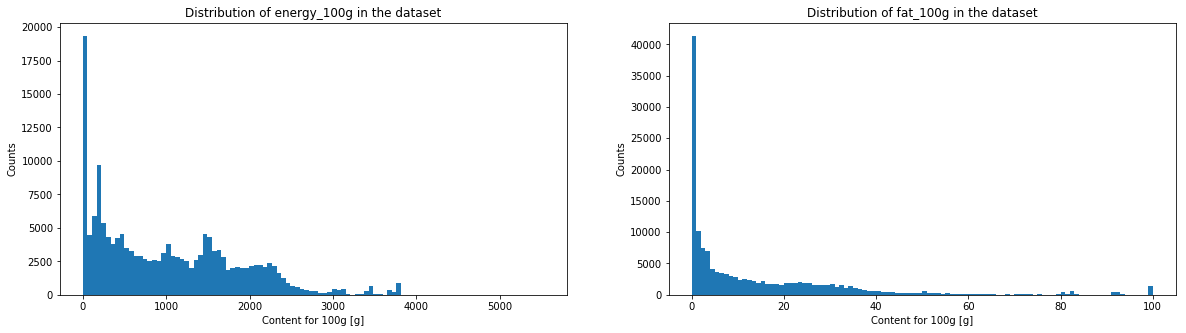

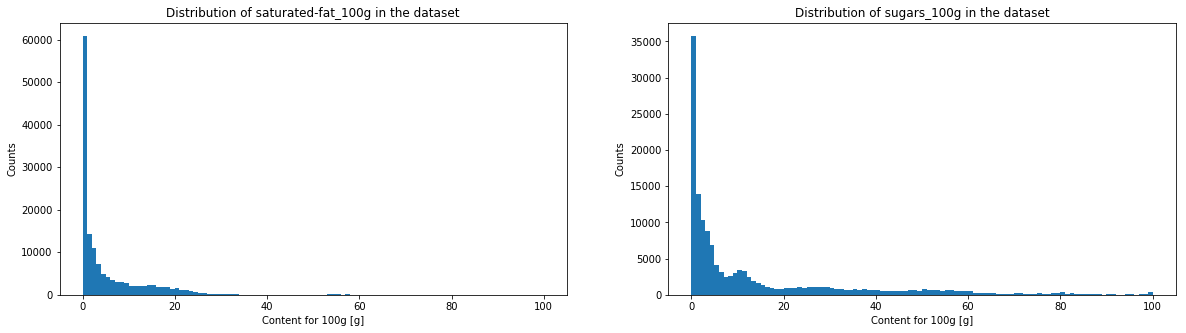

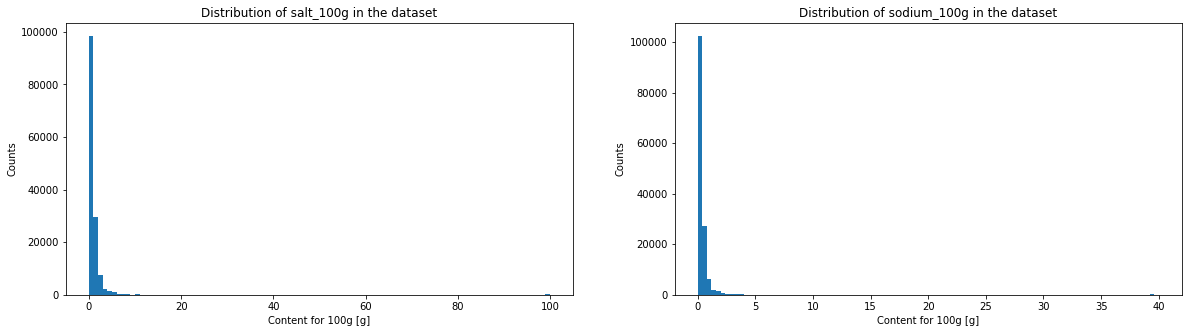

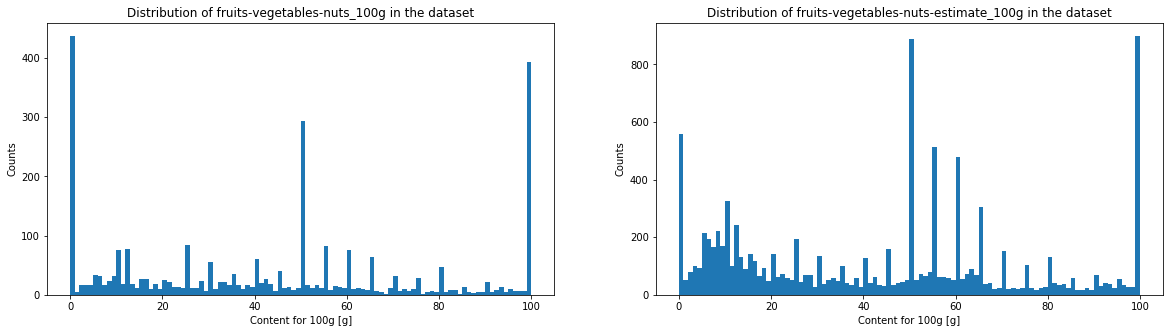

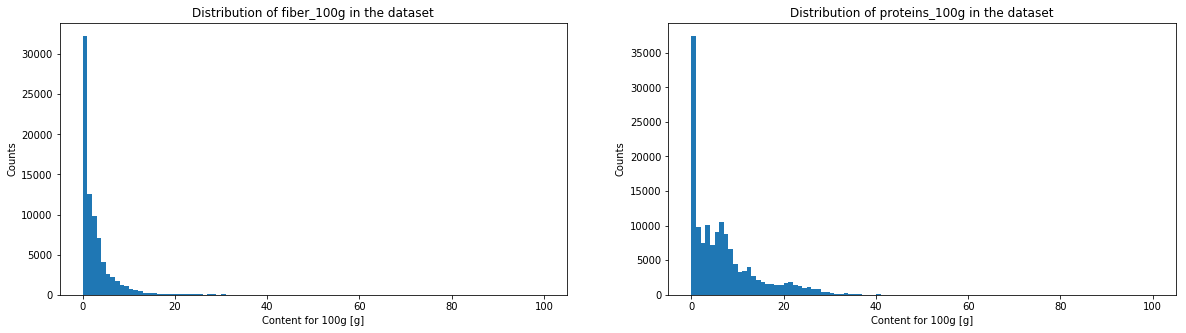

In [108]:
i = 1
for index in range(2, len(data_food.columns)):
    column = data_food.columns[index]

    if i > 2:
        i = i - 2
    if i == 1:
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, i)
   
    plt.hist(data_food[column], bins = 100);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    if i == 2:
        plt.show()
    i = i + 1

In [100]:
data_food.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.817607,0.618850,0.292799,-0.036228,-0.036232,-0.172822,-0.177592,0.244815,0.224569
fat_100g,0.817607,1.000000,0.730859,-0.057920,-0.008548,-0.008553,-0.165297,-0.175415,0.065044,0.138292
saturated-fat_100g,0.618850,0.730859,1.000000,0.042599,-0.012503,-0.012503,-0.221458,-0.282479,0.022232,0.141980
sugars_100g,0.292799,-0.057920,0.042599,1.000000,-0.086998,-0.086999,0.081503,0.086160,0.026772,-0.235284
salt_100g,-0.036228,-0.008548,-0.012503,-0.086998,1.000000,0.999999,-0.103775,-0.074703,-0.004394,0.066834
sodium_100g,-0.036232,-0.008553,-0.012503,-0.086999,0.999999,1.000000,-0.103773,-0.074701,-0.004394,0.066820
fruits-vegetables-nuts_100g,-0.172822,-0.165297,-0.221458,0.081503,-0.103775,-0.103773,1.000000,0.999981,0.104843,-0.212345
fruits-vegetables-nuts-estimate_100g,-0.177592,-0.175415,-0.282479,0.086160,-0.074703,-0.074701,0.999981,1.000000,0.102658,-0.210708
fiber_100g,0.244815,0.065044,0.022232,0.026772,-0.004394,-0.004394,0.104843,0.102658,1.000000,0.251992
proteins_100g,0.224569,0.138292,0.141980,-0.235284,0.066834,0.066820,-0.212345,-0.210708,0.251992,1.000000


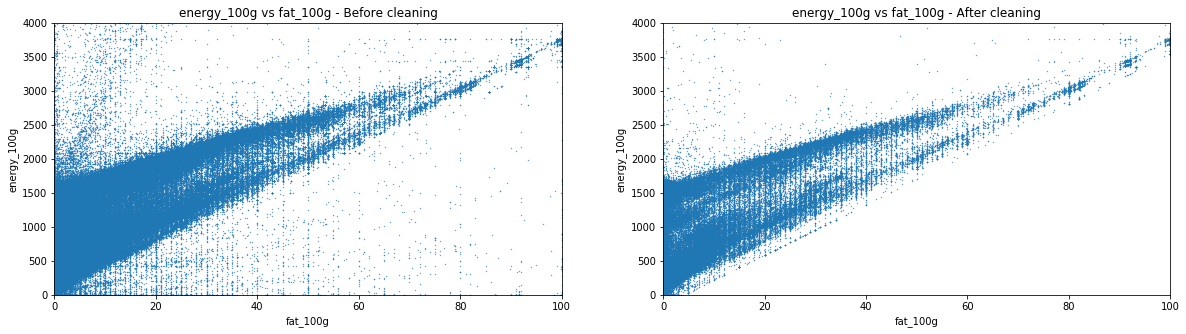

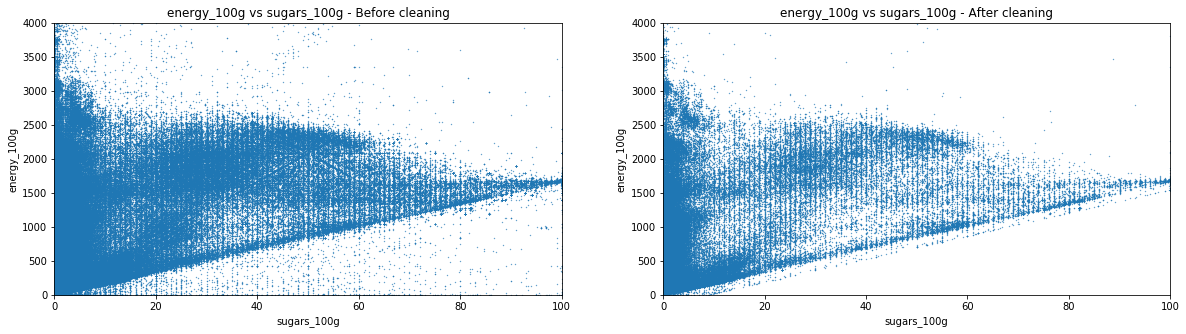

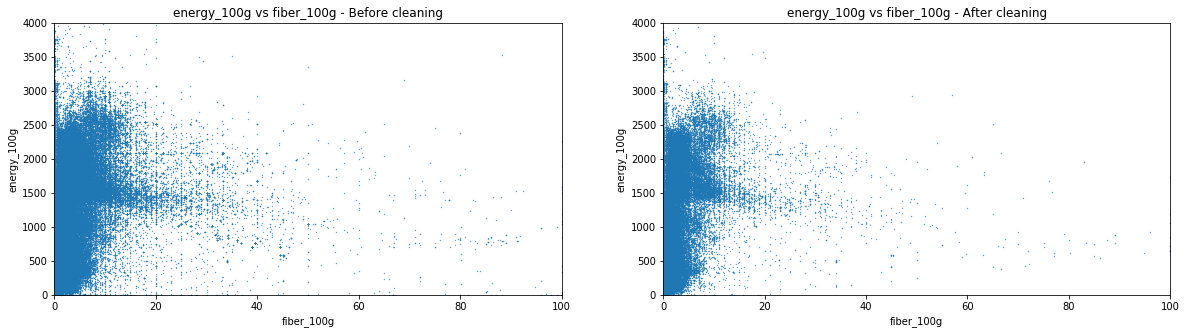

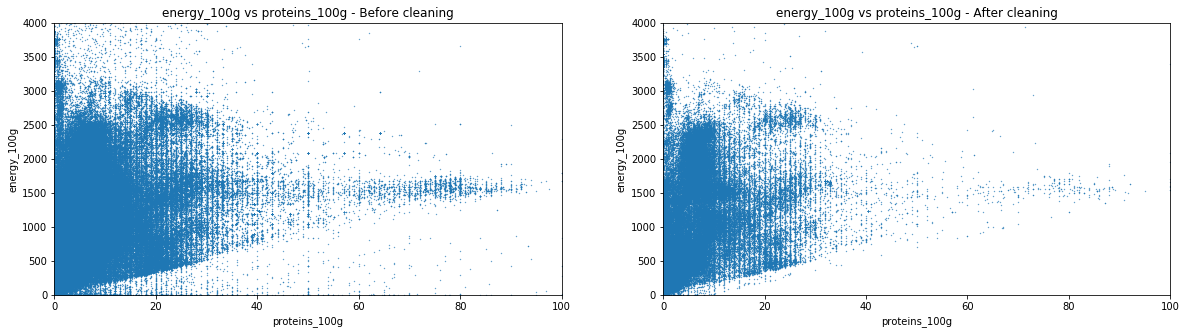

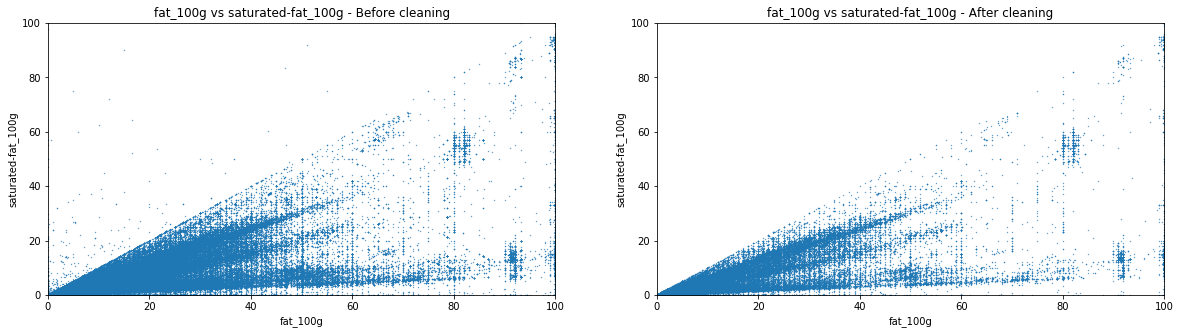

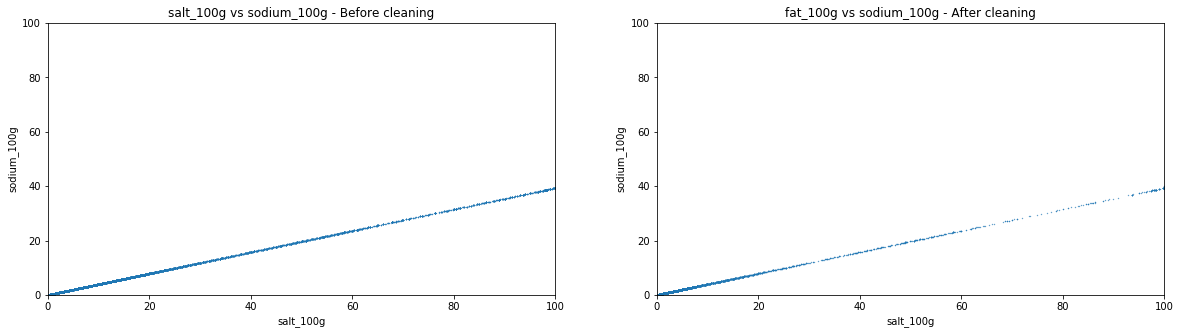

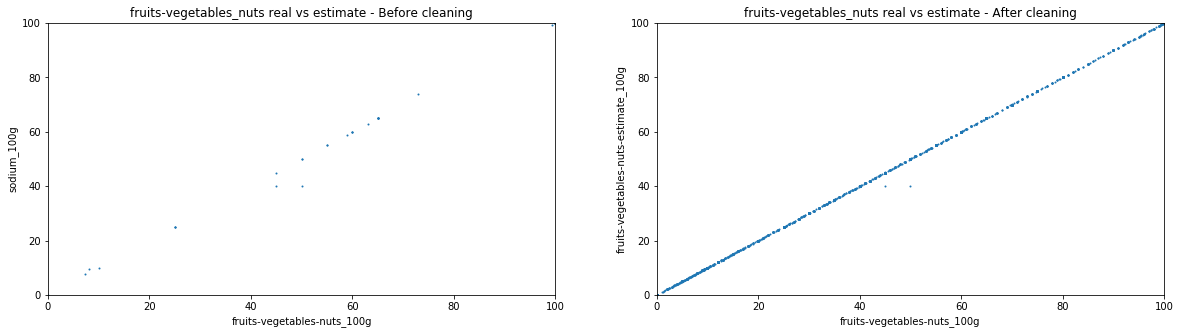

In [101]:
plt_with_energy = [3, 5, 10, 11]

for i_col in range(len(plt_with_energy)):
    x_col = data_food.columns[plt_with_energy[i_col]]
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(data_raw[x_col],data_raw['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - Before cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);
    

    plt.subplot(1, 2, 2)
    plt.scatter(data_food[x_col],data_food['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);

    plt.show()
    

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_raw['fat_100g'],data_raw['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - Before cleaning');
plt.ylabel('saturated-fat_100g');
plt.xlabel('fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 2, 2)
plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After cleaning');
plt.ylabel('saturated-fat_100g');
plt.xlabel('fat_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_raw['salt_100g'],data_raw['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - Before cleaning');
plt.ylabel('sodium_100g');
plt.xlabel('salt_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 2, 2)
plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('fat_100g vs sodium_100g - After cleaning');
plt.ylabel('sodium_100g');
plt.xlabel('salt_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_raw['fruits-vegetables-nuts_100g'],data_raw['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - Before cleaning');
plt.ylabel('sodium_100g');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 2, 2)
plt.scatter(data_food['fruits-vegetables-nuts_100g'],data_food['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After cleaning');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.axis([0, 100, 0, 100]);
plt.show()


In [111]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = data_food.join(data_nutriscore)

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

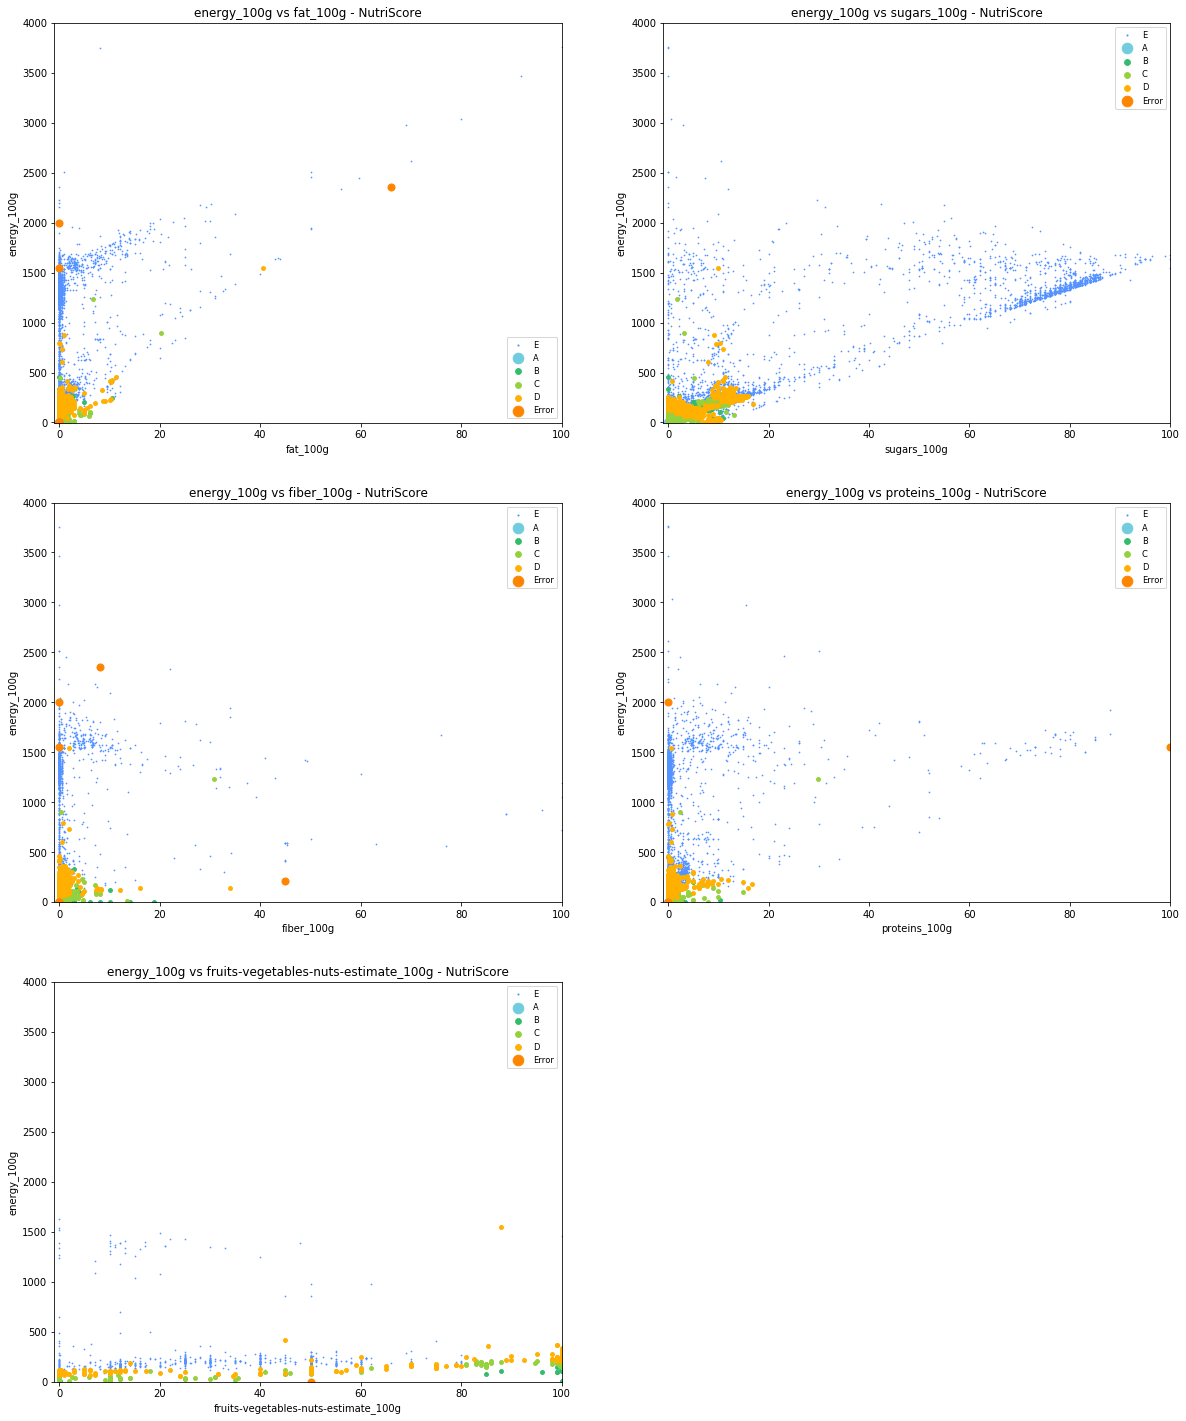

In [180]:
data_food_nutri_beverages_A = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_beverages_B = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_beverages_C = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_beverages_D = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_beverages_E = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'e']

Color = ['#5392ff','#71cddd', '#34bc6e', '#95d13c', '#ffb000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fat_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fat_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fat_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fat_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);
ax.scatter(data_food_nutri_beverages_E['fat_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['sugars_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['sugars_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['sugars_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['sugars_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);
ax.scatter(data_food_nutri_beverages_E['sugars_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fiber_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fiber_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fiber_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fiber_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);
ax.scatter(data_food_nutri_beverages_E['fiber_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['proteins_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['proteins_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['proteins_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['proteins_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);
ax.scatter(data_food_nutri_beverages_E['proteins_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);
ax.scatter(data_food_nutri_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);


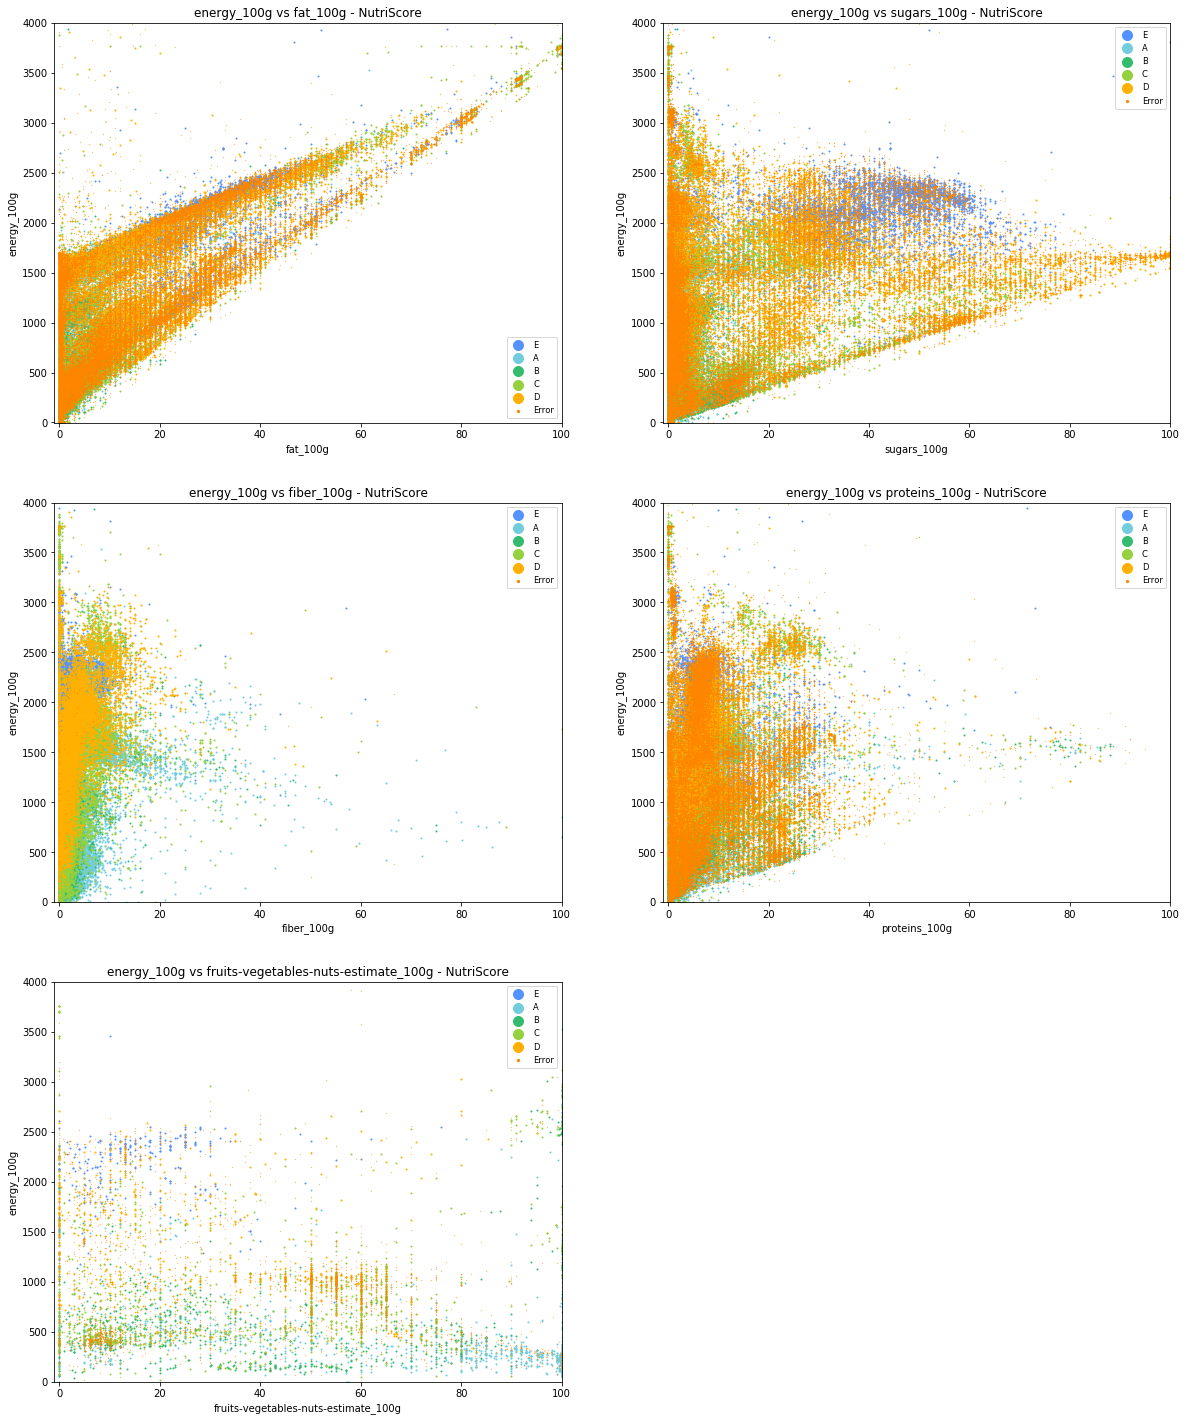

In [176]:
data_food_nutri_non_beverages_A = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_non_beverages_B = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_non_beverages_C = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_non_beverages_D = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_non_beverages_E = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'e']

Color = ['#5392ff','#71cddd', '#34bc6e', '#95d13c', '#ffb000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fat_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fat_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fat_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fat_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fat_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['sugars_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['sugars_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['sugars_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['sugars_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['sugars_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fiber_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fiber_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fiber_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fiber_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fiber_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['proteins_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['proteins_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['proteins_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['proteins_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['proteins_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

### NutriScore - Computation

In [109]:
data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

In [125]:
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
labels = ['a', 'b', 'c', 'd', 'e', 'Error']
confusion_matrix_ = confusion_matrix(y_true, y_pred, labels=['a', 'b', 'c', 'd', 'e', 'Error'])
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index = labels, columns = labels)

,a,b,c,d,e,Error
a,13997,525,208,11,12,3969
b,107,11301,662,68,46,6807
c,90,92,16240,693,37,10849
d,21,53,1221,18064,285,19679
e,3,54,457,379,16319,13537
Error,0,0,0,0,0,0


In [113]:
print("For Beverages :\n")
ratio_grade = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == data_food_nutri_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_beverages)
ratio_score = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition-score-fr_100g'] == data_food_nutri_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

print("For non-Beverages :\n")
ratio_grade = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == data_food_nutri_non_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_non_beverages)
ratio_score = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition-score-fr_100g'] == data_food_nutri_non_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_non_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

For Beverages :

The accuracy according to the grade is 94.4513329200248 %, the accuracy according to the score is 84.36453812771234 %.

For non-Beverages :

The accuracy according to the grade is 50.71705555926991 %, the accuracy according to the score is 46.54426021260948 %.

